<a href="https://colab.research.google.com/github/therealdandecker/ColabNotebooks/blob/main/MSIS_645_Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Question 1 - Missing Data for Data set

https://foxweb.marist.edu/users/jf4n/DATA_FILES/wisc_bc_data.xlsx

In [8]:
import pandas as pd
from sqlalchemy import create_engine

#Create SQL Engine with SQLite
conn = create_engine('sqlite:///:memory')

# Load the dataset
url = 'https://foxweb.marist.edu/users/jf4n/DATA_FILES/wisc_bc_data.xlsx'
data = pd.read_excel(url)

# pass data to SQL
data.to_sql('wisc_data',conn,index=False, if_exists='replace')

results = pd.read_sql('select * from wisc_data', conn)

#Ok, 32 columns is a lot, I could use information schema and write dynamic sql to loop through the structures and find nulls
#which I might still do, or we could look use isnull() df

nulls = data.isnull().sum()
print(nulls)

#now that I know the nulls, lets get the ids for those rows to exclude them from pre-processing and build a new df
clean_data = pd.read_sql('''
with MissingData as (
  select id from wisc_data where radius_mean is null
  union
  select id from wisc_data where symmetry_mean is null
  union
  select id from wisc_data where smoothness_se is null
  union
  select id from wisc_data where dimension_se is null
  union
  select id from wisc_data where perimeter_worst is null
  union
  select id from wisc_data where symmetry_worst is null
)

select * from wisc_data wd
  --not exists will filter out the IDs we identified as missing data
  where not exists (
    select 1
    from MissingData md
      where md.id=wd.id
      )

''', conn

)

#verify we cleaned it up right
new_nulls = clean_data.isnull().sum()
print(new_nulls)




id                   0
diagnosis            0
radius_mean          1
texture_mean         0
perimeter_mean       0
area_mean            0
smoothness_mean      0
compactness_mean     0
concavity_mean       0
points_mean          0
symmetry_mean        2
dimension_mean       0
radius_se            0
texture_se           0
perimeter_se         0
area_se              0
smoothness_se        2
compactness_se       0
concavity_se         0
points_se            0
symmetry_se          0
dimension_se         2
radius_worst         0
texture_worst        0
perimeter_worst      1
area_worst           0
smoothness_worst     0
compactness_worst    0
concavity_worst      0
points_worst         0
symmetry_worst       1
dimension_worst      0
dtype: int64
id                   0
diagnosis            0
radius_mean          0
texture_mean         0
perimeter_mean       0
area_mean            0
smoothness_mean      0
compactness_mean     0
concavity_mean       0
points_mean          0
symmetry_mean        

Question 2: Visualize Data

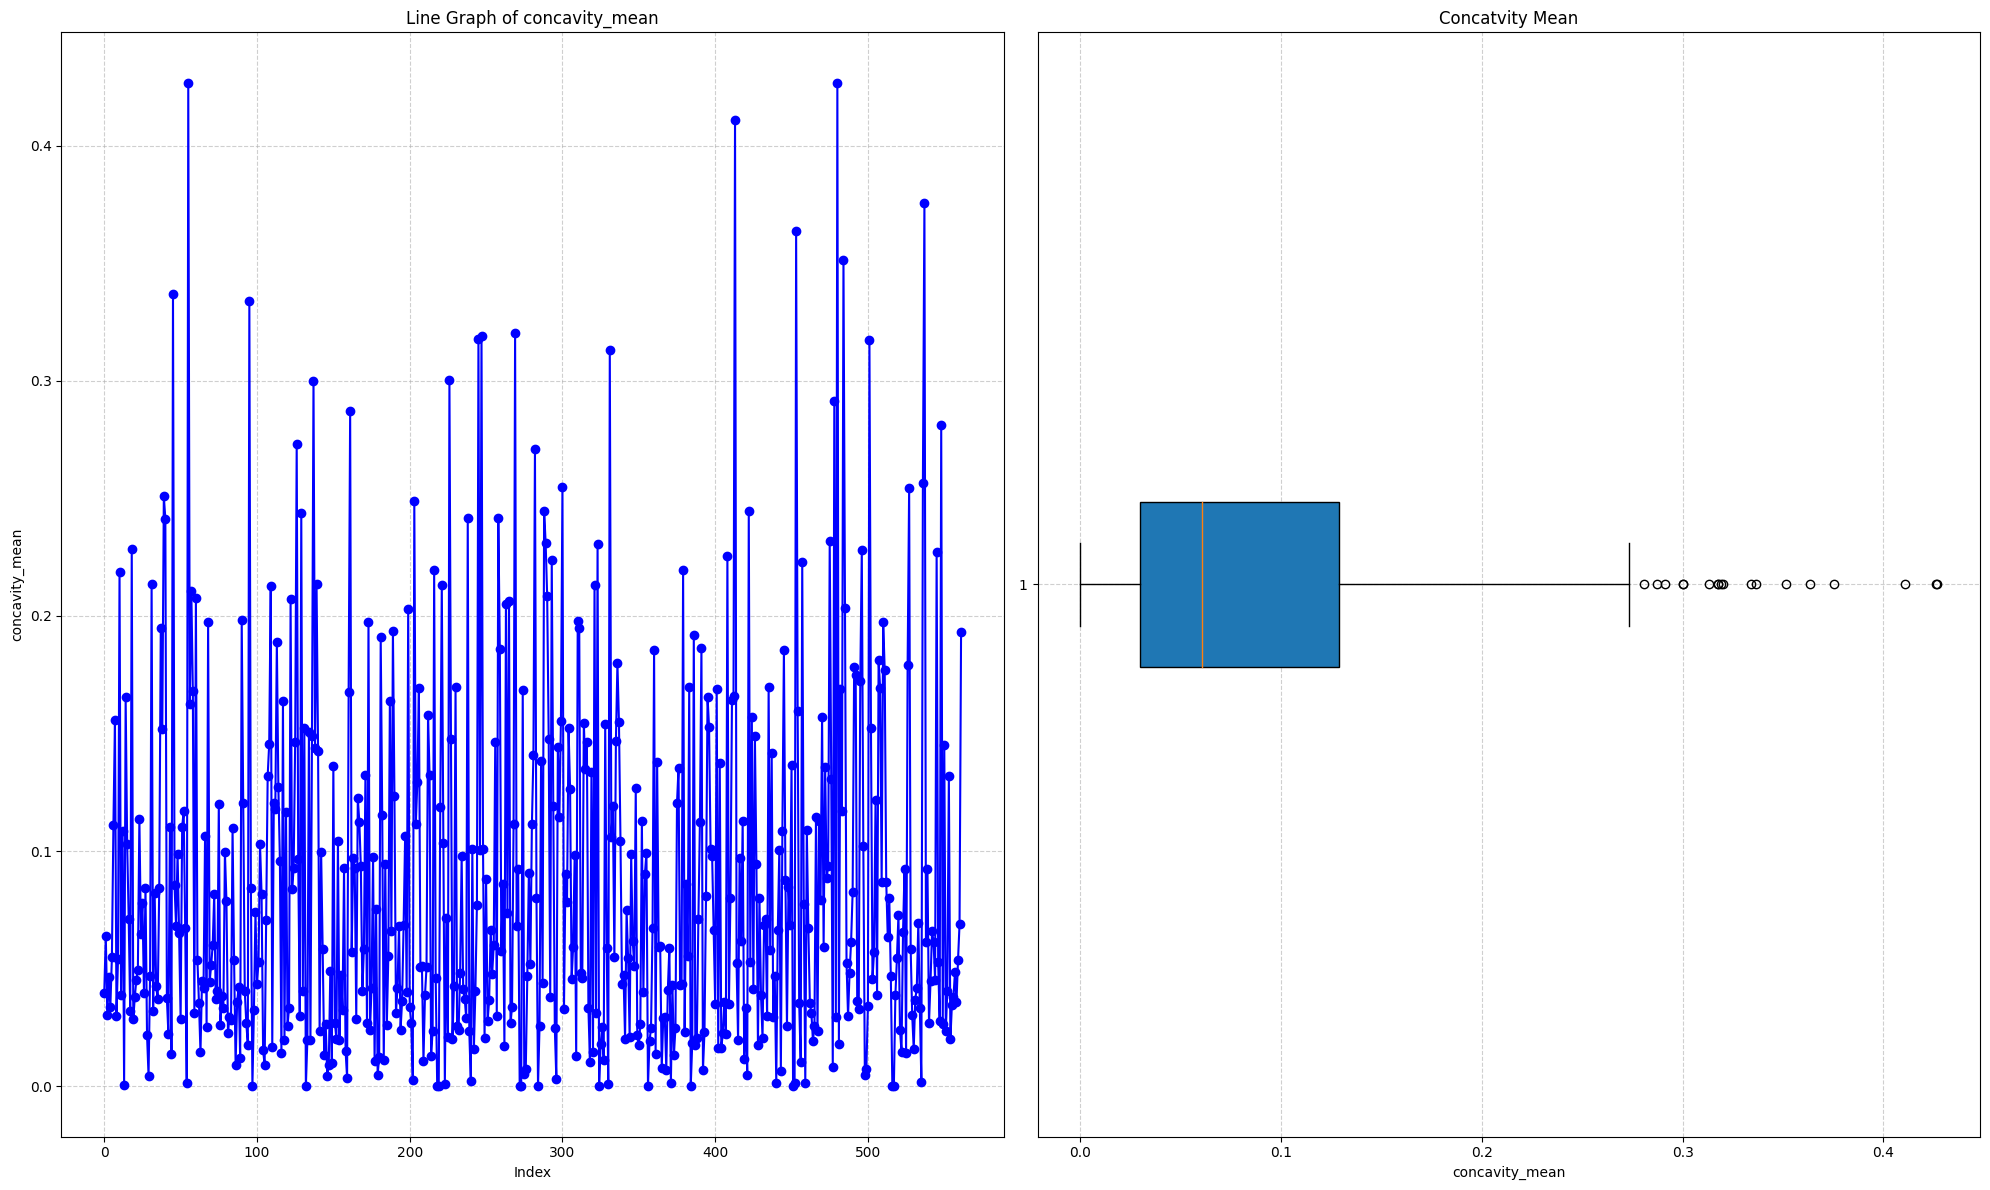

In [13]:
import matplotlib.pyplot as plts

plts.figure(figsize=(20,12))

# Line Graph
plts.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plts.plot(clean_data['concavity_mean'], marker='o', linestyle='-', color='b')
plts.title('Line Graph of concavity_mean')
plts.xlabel('Index')
plts.ylabel('concavity_mean')
plts.grid(True, linestyle='--', alpha=0.6)

# Box Plot
plts.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plts.boxplot(clean_data['concavity_mean'], vert=False, patch_artist=True)
plts.title('Concatvity Mean')
plts.xlabel('concavity_mean')
plts.grid(True, linestyle='--', alpha=0.6)

# Adjust layout to prevent overlapping
plts.tight_layout()

# Display the plots
plts.show()

Question 3 - Radius Mean Transformation

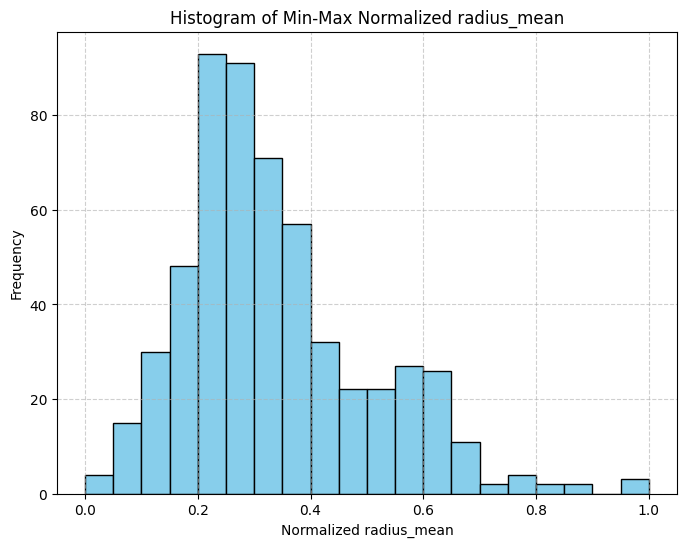

In [14]:
# Min-Max Normalization of radius_mean
clean_data['radius_mean_normalized'] = (clean_data['radius_mean'] - clean_data['radius_mean'].min()) / (clean_data['radius_mean'].max() - clean_data['radius_mean'].min())

# Plotting the normalized radius_mean
plts.figure(figsize=(8, 6))
plts.hist(clean_data['radius_mean_normalized'], bins=20, color='skyblue', edgecolor='black')
plts.title('Histogram of Min-Max Normalized radius_mean')
plts.xlabel('Normalized radius_mean')
plts.ylabel('Frequency')
plts.grid(True, linestyle='--', alpha=0.6)
plts.show()


Question 4 - Transform metrics to z-scores

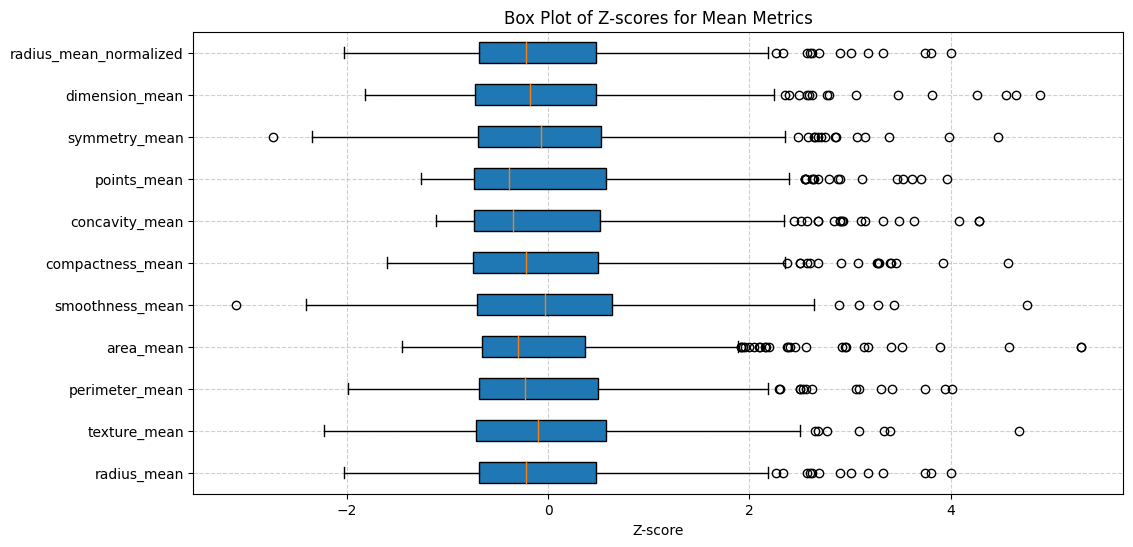

In [17]:
# Z-score Normalization for mean columns
mean_columns = clean_data.filter(like='_mean').columns
clean_data[mean_columns] = (clean_data[mean_columns] - clean_data[mean_columns].mean()) / clean_data[mean_columns].std()

# Box Plot for Z-scores of all _mean columns
plts.figure(figsize=(12, 6))
plts.boxplot([clean_data[col] for col in mean_columns], labels=mean_columns, vert=False, patch_artist=True)
plts.title('Box Plot of Z-scores for Mean Metrics')
plts.xlabel('Z-score')
plts.grid(True, linestyle='--', alpha=0.6)
plts.show()

Question 5 - investigate correlated variables

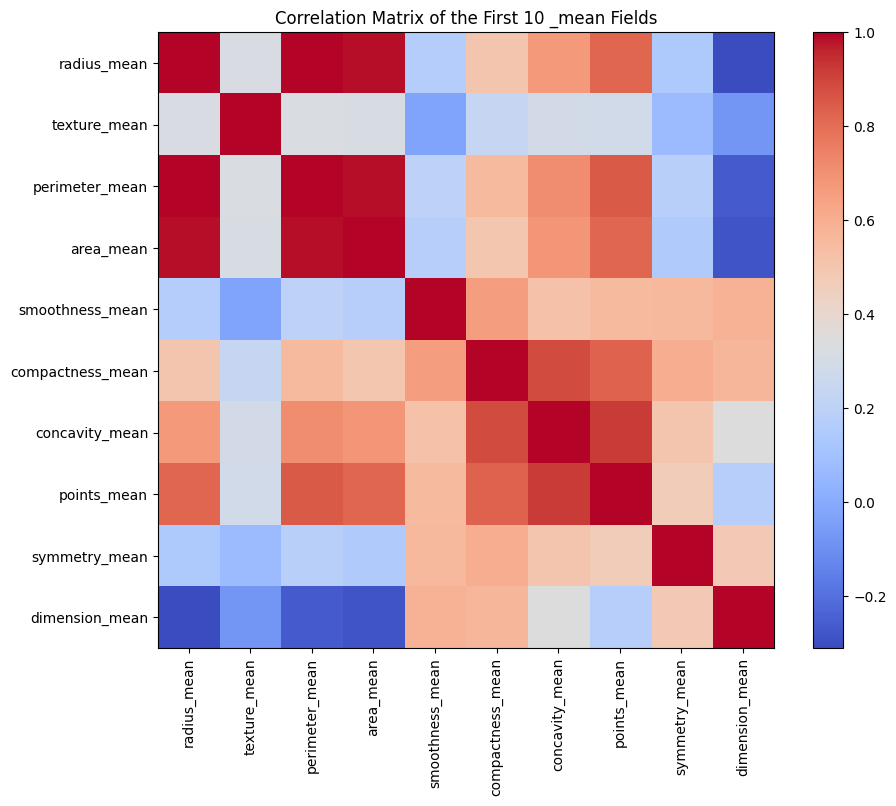

In [16]:
import numpy as np

# Correlation matrix for the first 10 _mean fields
corr_matrix = clean_data[mean_columns[:10]].corr()

# Heatmap-like visualization using imshow
plts.figure(figsize=(10, 8))
cax = plts.imshow(corr_matrix, cmap='coolwarm', interpolation='none')
plts.colorbar(cax)
plts.title('Correlation Matrix of the First 10 _mean Fields')
plts.xticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plts.yticks(np.arange(len(corr_matrix.columns)), corr_matrix.columns)
plts.grid(False)
plts.show()